In [28]:
import pandas as pd
import numpy as np
import networkx as nx
import networkx_viewer as nxview
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
from scipy import stats
from itertools import product

import as_proc as proc

# HOW TO USE
To perform the analysis of AS graph with this Jupyter Notebook, you have to:
 1. Specify in `data_dir` the directory containing monthly updates from CAIDA
 2. Specify in `routeviews_dir` the directory containing IPv4 to AS mappings
 2. Specify the starting date of the analysis in `starting_date`
 3. Specify the ending date of the analysis in `ending_date`

In [2]:
data_dir = "asdata/"
routeviews_dir = "ip2as/"

In [3]:
starting_date = {'year':2015, 'month':12}
ending_date = {'year':2020, 'month':5}

It's all set!

### Helper functions

In [4]:
def to_dict_key(year_param, month_param):
    return str(year_param) + str(month_param).zfill(2)

In [5]:
def to_date(point_key):
    return point_key[2:4] + '/' + point_key[4:]

In [129]:
# Max number of x-labels to show in graphs
xtick_max_num = 4

In [7]:
# Set save_figures to True, to save graphs as .svg files
save_figures = True
def save_svg(filename):
    if save_figures:
        plt.savefig("./figs/" + filename + ".svg")

In [29]:
mpl.style.use("seaborn")
mpl.rc('xtick', labelsize=20)
mpl.rc('ytick', labelsize=20)
mpl.rc('axes', labelsize=20)
mpl.rc('legend', fontsize=14)

## Load CAIDA data

Relation types to IDs conversion (adopted to numerically manipulate numpy arrays):
    - peer-peer:         0
    - provider-customer:-1
    - customer-provider: 1

In [8]:
as_data = dict()

for (year, month) in product(range(starting_date['year'], ending_date['year']+1), range(1, 13)):
    if not ((year == starting_date['year'] and month < starting_date['month']) or 
        (year == ending_date['year'] and month > ending_date['month'])):
        date_label = to_dict_key(year, month)
        as_data[date_label] = proc.load_graph(data_dir + date_label + "01.as-rel2.txt")

For each time $k$ (which represents a particular month), I denote with $\Gamma_k = (A^k, E^k)$ the AS graph. $A^k$ is the set of nodes and $E^k$ is the set of edges.

## Save edges for simulation

In [ ]:
# edges_num_by_node = 
# np.savetxt("simulation/202003-nodes.csv")

Select here **year** and **month** to export a *.csv* suitable for the simulation

In [ ]:
for_simulation = '202003'
data_point = as_data[for_simulation]['edges']

In [ ]:
# Also need to sort according to the destination AS, to use binary search in simulator!!
dp_by_as = np.split(data_point, np.unique(data_point[:,0], return_index=True)[1])[1:]

In [ ]:
dp_by_as_sorted = [x[np.argsort(x[:,1]),:] for x in dp_by_as]

In [ ]:
#
# OPTIMIZATION
# Apply stub AS reduction
#
stub_as = np.squeeze(np.array(list(filter(lambda x: len(x) == 1, map(lambda x: x[:,0], dp_by_as_sorted)))))
non_stub_as = np.setdiff1d(as_data[for_simulation]['nodes'], stub_as)
stub_as, non_stub_as

In [ ]:
# Delete stub ASes
dp_filtered = list(filter(lambda x: len(x) > 1, dp_by_as_sorted))
# Delete references in destinations
dp_filtered = [x[np.in1d(x[:,1], non_stub_as),:] for x in dp_filtered]

In [ ]:
print("Applied stub AS reduction: factor %f %%, from %d to %d nodes" % (len(dp_filtered)/float(len(dp_by_as))*100, len(dp_by_as), len(dp_filtered)))

In [ ]:
to_export_full = np.concatenate(dp_by_as_sorted)
to_export_full

In [ ]:
to_export = np.concatenate(dp_filtered)
to_export

In [ ]:
# Complete dataset
np.savetxt("./simulation/data/" + for_simulation + "-full-edges.csv", to_export_full, fmt='%d', delimiter=',')

In [ ]:
# Reduced dataset
np.savetxt("./simulation/data/" + for_simulation + "-edges.csv", to_export, fmt='%d', delimiter=',')

In [ ]:
to_export[-10:]

## Load IP prefixes (Routeviews)

In [19]:
ip2as_file = pd.read_csv(routeviews_dir + "routeviews_2003.pfx2as", sep='\t')

In [20]:
conversions = ip2as_file.to_numpy()

In [21]:
conversions = conversions[:, [2, 1, 0]]
conversions.shape

(852307, 3)

In [22]:
# For multihomed sites: Take the first AS origin
multi_homed_idxs = np.where(np.vectorize(lambda x: '_' in x)(conversions[:,0]))
if multi_homed_idxs[0].shape[0] > 0:
    conversions[multi_homed_idxs, 0] = np.vectorize(lambda x: x.split('_')[0])(conversions[multi_homed_idxs, 0])

In [23]:
# For AS sets: Take only the first one
as_sets_idxs = np.where(np.vectorize(lambda x: ',' in x)(conversions[:,0]))
if as_sets_idxs[0].shape[0] > 0:
    conversions[as_sets_idxs, 0] = np.vectorize(lambda x: x.split(',')[0])(conversions[as_sets_idxs, 0])

In [24]:
# Converting AS numbers to 64-byte integers
conversions[:,0] = conversions[:,0].astype('int64')

In [25]:
conversions

array([[56203, 22, '1.0.4.0'],
       [56203, 24, '1.0.4.0'],
       [56203, 24, '1.0.5.0'],
       ...,
       [58519, 24, '223.255.252.0'],
       [58519, 24, '223.255.253.0'],
       [55415, 24, '223.255.254.0']], dtype=object)

## Processing differences

### Nodes evolution

#### By month

In [9]:
x_vals = list(as_data.keys())
x_vals.sort()

In [10]:
as_variations = []
for (bk, nx) in zip(x_vals[:-1], x_vals[1:]):
    as_down = np.setdiff1d(as_data[bk]['nodes'], as_data[nx]['nodes'])
    as_up = np.setdiff1d(as_data[nx]['nodes'], as_data[bk]['nodes'])
    as_variations.append([as_down.shape[0]/float(as_data[bk]['nodes'].shape[0]),
                          as_up.shape[0]/float(as_data[nx]['nodes'].shape[0])])
    
as_variations = np.array(as_variations) * 100

`as_variations` is a *numpy* array of the form: \
$$   [[d_0, a_0],\\ [d_1. a_1],\\ ... \\ [d_n, a_n]]  $$
where:
 - $d_k$ is the percentage of AS nodes, included at time `k`, that disappeared at time `k+1`
 - $a_k$ is the percentage of new ASes, i.e. those included at `k+1` that were absent at time `k` 

In [130]:
#Define x-axis labels
as_graph_x_label = list(map(lambda x: to_date(x[0]) + " to \n " + to_date(x[1]), zip(x_vals[:-1], x_vals[1:])))
graph_ticks_step = int(len(as_graph_x_label)/xtick_max_num)
if graph_ticks_step < 1:
    graph_ticks_step = 1
    
as_graph_x_ticks = as_graph_x_label[0::graph_ticks_step]

as_graph_cumul_x_label = list(map(lambda x: to_date(x), x_vals))
cumul_ticks_step = int(len(as_graph_cumul_x_label)/xtick_max_num)
if cumul_ticks_step < 1:
    cumul_ticks_step = 1
    
as_graph_cumul_x_ticks = as_graph_cumul_x_label[0::cumul_ticks_step]

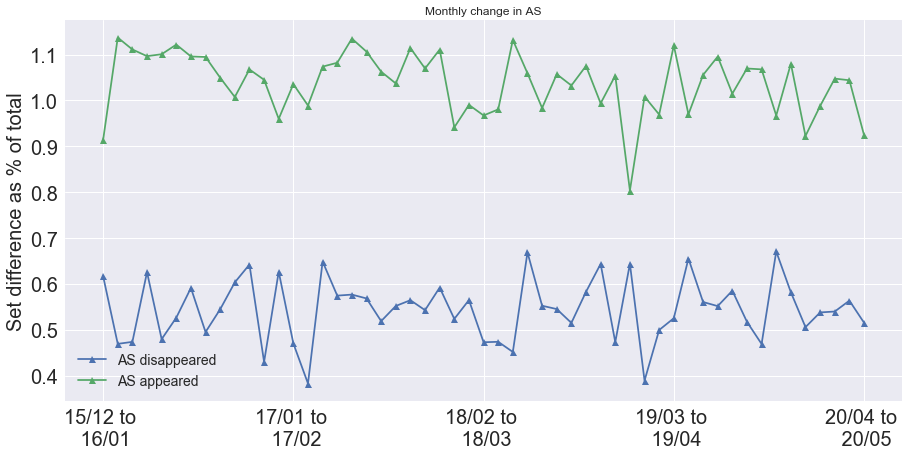

In [131]:
plt.figure(figsize=(15, 7))
plt.plot(as_graph_x_label, as_variations[:,0], '^-', label='AS disappeared')
plt.plot(as_graph_x_label, as_variations[:,1], '^-', label='AS appeared')
plt.ylabel('Set difference as % of total')
plt.title('Monthly change in AS')
plt.xticks(as_graph_x_ticks)
plt.legend()

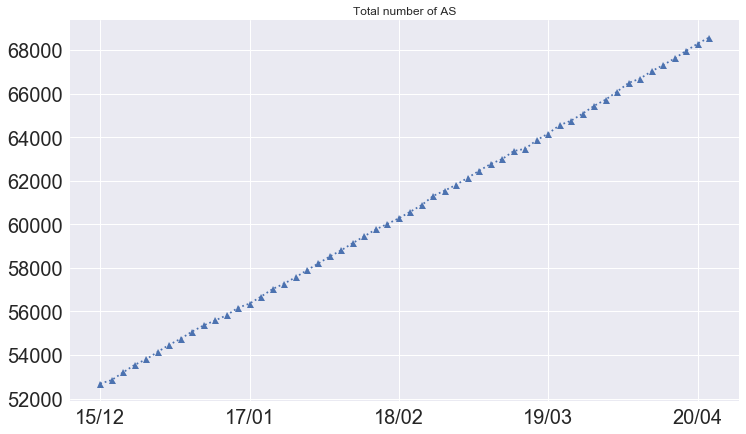

In [132]:
tot_as_num_by_month = [len(as_data[x]['nodes']) for x in x_vals]
plt.figure(figsize=(12, 7))
plt.plot(as_graph_cumul_x_label, tot_as_num_by_month, ':^')
plt.title("Total number of AS")
plt.xticks(as_graph_cumul_x_ticks);

#### Cumulative
Here, cumulative differences are shown

In [14]:
# The list of ASes at the starting date
union_set = as_data[to_dict_key(starting_date['year'], starting_date['month'])]['nodes']
union_size = float(union_set.shape[0])
intersect_set = as_data[to_dict_key(starting_date['year'], starting_date['month'])]['nodes']
intersect_size = float(intersect_set.shape[0])

In [15]:
as_cumul_variations = []
for mth in x_vals:
    as_down = np.setdiff1d(intersect_set, as_data[mth]['nodes'])
    as_up = np.setdiff1d(as_data[mth]['nodes'], union_set)
    as_cumul_variations.append([as_down.shape[0]/intersect_size, as_up.shape[0]/float(as_data[mth]['nodes'].shape[0])])
    union_set = np.union1d(union_set, as_data[mth]['nodes'])
    union_size = float(union_set.shape[0])
    intersect_set = np.intersect1d(intersect_set, as_data[mth]['nodes'])
    intersect_size = float(intersect_set.shape[0])
    
as_cumul_variations = np.array(as_cumul_variations) * 100

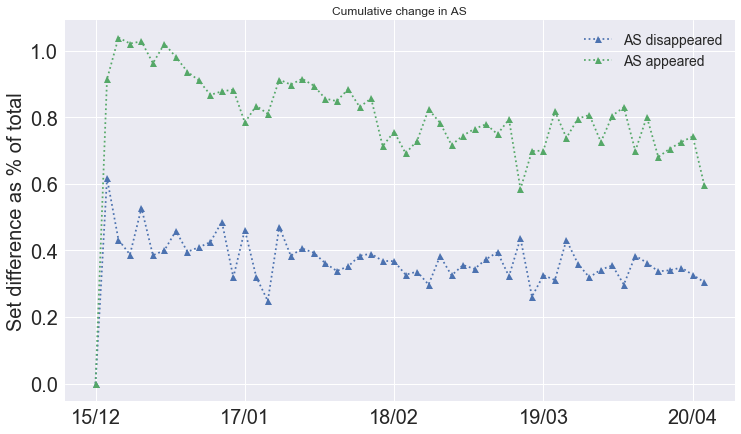

In [133]:
plt.figure(figsize=(12, 7))
plt.plot(as_graph_cumul_x_label, as_cumul_variations[:,0], '^:', label='AS disappeared')
plt.plot(as_graph_cumul_x_label, as_cumul_variations[:,1], '^:', label='AS appeared')
plt.ylabel('Set difference as % of total')
plt.title('Cumulative change in AS')
plt.xticks(as_graph_cumul_x_ticks)
plt.legend()

**TODO**: Use final intersection

For time $k$, `AS appeared` is the number (as percentage) of ASes that had never happeared before, namely: \
$$ \frac{\big \lvert A^k \setminus \bigcup_{j=0}^{k-1} A^j \big \rvert}{\lvert A^k \rvert} $$

`AS disappeared` is the percentage of ASes always present up to time $k-1$ that are not found at time $k$, i.e. \
$$ \frac{\big \lvert \bigcap_{j=0}^{k-1} A^j \setminus A^k \big \rvert}{\big \lvert \bigcap_{j=0}^{k-1} A^j \big \rvert} $$

Now, I repeat the last analysis taking advantage of information from the future. At each time $k$, I calculate the percentage of ASes that differ from the intersection (here, always calculated over the entire period)

In [17]:
as_future_variations = []
for mth in x_vals:
    as_var = np.setdiff1d(as_data[mth]['nodes'], intersect_set)
    as_future_variations.append(as_var.shape[0]/as_data[mth]['nodes'].shape[0])
    
as_future_variations = np.array(as_future_variations) * 100

In [18]:
as_future_variations

array([17.98288068, 18.22809242, 18.7767837 , 19.29706613, 19.67956582,
       20.18101219, 20.65875959, 21.06166886, 21.5375118 , 21.93579854,
       22.25320692, 22.58607717, 23.06432374, 23.32233223, 23.75793931,
       24.22185982, 24.54602598, 24.93138311, 25.35281823, 25.75679483,
       26.16273109, 26.52304763, 26.92932026, 27.31645783, 27.69588569,
       27.99946684, 28.30764637, 28.66387137, 29.02706609, 29.51212749,
       29.78927359, 30.09366356, 30.45367494, 30.81553585, 31.15830054,
       31.40090483, 31.80146769, 31.9110719 , 32.33433546, 32.65385634,
       33.05655818, 33.26847648, 33.60068836, 33.96393643, 34.24928489,
       34.6143953 , 35.00774541, 35.20167941, 35.5265121 , 35.79663636,
       36.08720088, 36.41353129, 36.72079776, 36.98102752])

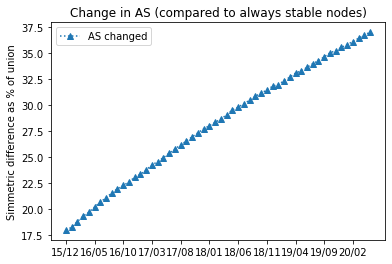

In [19]:
#plt.figure(figsize=(12, 7))
plt.plot(as_graph_cumul_x_label, as_future_variations, '^:', label='AS changed')
plt.ylabel('Simmetric difference as % of union')
plt.title('Change in AS (compared to always stable nodes)')
plt.xticks(as_graph_cumul_x_ticks)
plt.legend()

### Study of unstable ASes

In [20]:
# Delete AS that are not included in the union of nodes over the period
conversions = conversions[np.where(conversions[:,0] <= union_set.max())]

NameError: name 'conversions' is not defined

In [ ]:
# Compute the number of addresses advertised by each AS
def calc_as_addr_sum(as_information):
    as_information = as_information[np.argsort(as_information[:,0]), :]
    _, as_idxs = np.unique(as_information[:,0], return_index=True)
    by_as_list = np.split(as_information, as_idxs[1:])
    return np.array([[x[0,0], (1 << (32-x[:,1])).sum()] for x in by_as_list])

In [ ]:
unstable_as = np.setdiff1d(union_set, intersect_set)

In [ ]:
unstable_prefixes = conversions[np.where(np.in1d(conversions[:,0], unstable_as)),:]

In [ ]:
unstable_prefixes = unstable_prefixes[0]

I now estimate the difference in the average number of IP prefixes advertised between the unstable AS and general average. This should give information on the *size* of the unstable ASes

In [ ]:
as_addr_num = calc_as_addr_sum(conversions)

In [ ]:
unstable_addr_num = calc_as_addr_sum(unstable_prefixes)

In [ ]:
print("The general average number of IP addresses per AS is %d whereas, for unstable IPs, it's %d" 
          % (np.average(as_addr_num[:,1]), np.average(unstable_addr_num[:,1])))

This results indicates that, on average, a random AS advertises about **10 times more** IP addresses that a typical *unstable AS*

### Edges evolution

Below, I use the following terms:
 - **stable nodes**: nodes that always appear in data (spanning a certain number of months)
 
Let $S^k = \bigcap_{j=0}^{k-1} A^j$, I denote with $\Gamma_{S^k} = \Gamma \rvert_{S^k}$ the induced subgraph. Furthermore, if $N$ is the end of the period under analysis (the most recent available month), I write $S=S^N$. In other words, $S$ is the set of nodes that are stable across the entire period under examination, I call them **always stable** ($S \subset S^k \forall k$).

#### Global view

In [20]:
tot_edges_num = [as_data[x]['edges'].shape[0] / 2 for x in x_vals]

In [21]:
tot_peer_edges = [(as_data[x]['edges'][:,2] == 0).sum() / 2 for x in x_vals]

In [22]:
tot_cp_edges = [(as_data[x]['edges'][:,2] != 0).sum() / 2 for x in x_vals]

In [25]:
print("Ratio between number of edges in 2020 and 2015: %.3f" % (tot_cp_edges[-1] / float(tot_cp_edges[0])))

Ratio between number of edges in 2020 and 2015: 1.309


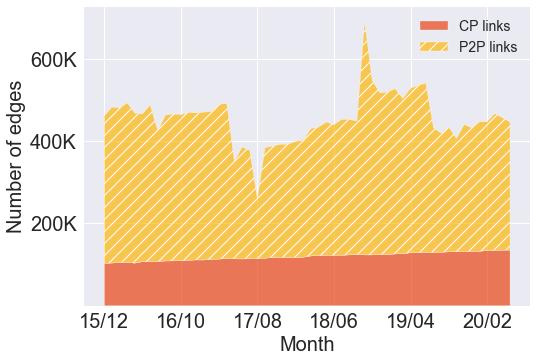

In [86]:
stacks = plt.stackplot(as_graph_cumul_x_label, tot_cp_edges, tot_peer_edges, labels=["CP links", "P2P links"], edgecolors=["white", "white"], colors=["#E73D0Aaa", "#FFB400aa"]) #, edgecolors=["#007BB0", "#FFB400"]) #, linewidth=3)
# Apply different hatches
#stacks[0].set_hatch("\\\\")
stacks[1].set_hatch("//")
#plt.title("Number of edges")
plt.xticks(as_graph_cumul_x_ticks[::2])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().set_yticks([200000, 400000, 600000])
plt.gca().set_yticklabels(["200K", "400K", "600K"])
plt.xlabel("Month")
plt.ylabel("Number of edges")
plt.legend();
save_svg("edges_by_type")

#### Edge stability
Which portion of edges appears/disappears from the graph?

In [87]:
# Find the edges of the subgraph
def filter_by_nodes(edges_param, nodes_to_keep):
    # Encode the edges as single 64 integer
    filtered_idxs = np.intersect1d(np.where(np.in1d(edges_param[:,0], nodes_to_keep)),
                                   np.where(np.in1d(edges_param[:,1], nodes_to_keep)))
    return edges_param[filtered_idxs,:]

`stable_edges` contains, for each month $k$, the edges (of $\Gamma^k$) connecting **always stable** nodes only. Hence `stable_edges[k]` = $E_{S}^k$

In [88]:
stable_edges = dict()
for i in x_vals:
    stable_edges[i] = filter_by_nodes(as_data[i]['edges'], intersect_set)

It's reasonable to just look at always stable nodes since, for each time $k$, the induced subgraph $\Gamma_{S}^k$ still contains the vast majority of edges of $\Gamma^k$. \
Below, I compute $m= \min_{k}{\Big(\frac{\lvert E_{S}^k \rvert}{\lvert E^k \rvert}\Big)}$ and $M= \max_{k}{\Big(\frac{\lvert E_{S}^k \rvert}{\lvert E^k \rvert}\Big)}$

In [89]:
print("Over the selected period, m = %.2f%% \t M = %.2f%%" % 
      (min([stable_edges[i].shape[0]/float(as_data[i]['edges'][:,0].shape[0]) for i in x_vals])*100, max([stable_edges[i].shape[0]/float(as_data[i]['edges'][:,0].shape[0]) for i in x_vals])*100))

Over the selected period, m = 70.99% 	 M = 87.80%


In [90]:
march_2020 = '202003'
print("In March 2020, the ratio is %.2f%%" % 
      ((stable_edges[march_2020].shape[0]/float(as_data[march_2020]['edges'][:,0].shape[0]))*100))

In March 2020, the ratio is 71.82%


Now, I encode each edge as a 64-bytes integer for fast comparison, edge $\varepsilon = (x, y)$ is encoded as $\varepsilon = x \cdot 10^6 + y$

In [91]:
fast_edges = dict()
for i in x_vals:
    fast_edges[i] = (stable_edges[i][:,0].astype('int64') * 1000000) + stable_edges[i][:,1].astype('int64')

In [92]:
edges_existence = []
for curr, nxt in zip(x_vals[:-1], x_vals[1:]):
    edges_existence.append([np.union1d(fast_edges[curr], fast_edges[nxt]).shape[0],
                            np.union1d(np.setdiff1d(fast_edges[curr], fast_edges[nxt]), np.setdiff1d(fast_edges[nxt], fast_edges[curr]))[:]])

In [93]:
edges_num_change = [tm[1].shape[0]/float(tm[0]) for tm in edges_existence]

`edges_num_change` is the fraction of edges in the stable subgraph $\Gamma_S^k$ that change after 1 month. In other words,

$$ \text{edges_num_change}[k] = \frac{\lvert E_S^k \triangle E_S^{k+1} \rvert}{\lvert E_S^k \cup E_S^{k+1}\rvert} $$
    
where $ \triangle $ denotes the symmetric set difference.

It can be seen that there is a relatively high variability, for instance 1 over 5 edges of the stable subgraph either appears or disappears between October and November 2019

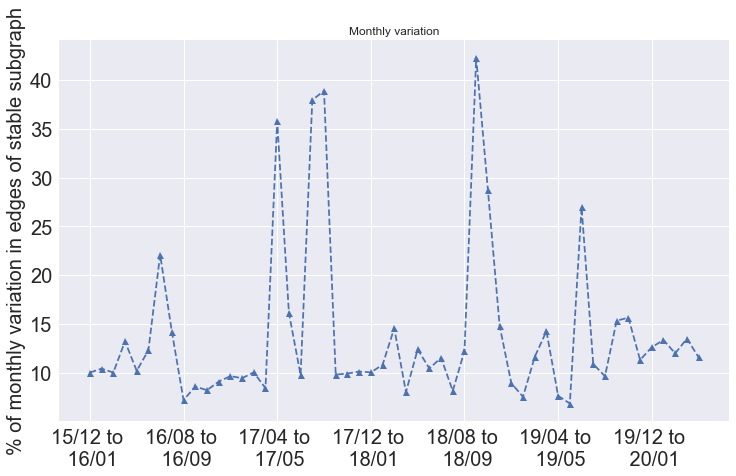

In [116]:
plt.figure(figsize=(12, 7))
plt.plot(as_graph_x_label, list(map(lambda x: 100* x, edges_num_change)), '^--')
plt.ylabel("% of monthly variation in edges of stable subgraph")
plt.xticks(as_graph_x_ticks)
plt.title("Monthly variation");

Although the previous graph gives an idea on the monthly amount of change in AS graph, it falls short of distinguishing between random fluctuations and real topology changes.

#### Cumulative edge change
How many edges are really new?

In [95]:
edge_novelty = []
edge_union = fast_edges[x_vals[0]]
edge_intersection = fast_edges[x_vals[0]]
for curr in x_vals:
    edge_novelty.append([fast_edges[curr].shape[0],
                         edge_intersection.shape[0],
                         np.setdiff1d(fast_edges[curr], edge_union),
                         np.setdiff1d(edge_intersection, fast_edges[curr])])
    edge_union = np.union1d(edge_union, fast_edges[curr])
    edge_intersection = np.intersect1d(edge_intersection, fast_edges[curr])

In [96]:
edge_novelty_fraction = [p[2].shape[0]/float(p[0]) for p in edge_novelty]
edge_disappearence_fraction = [p[3].shape[0]/float(p[1]) for p in edge_novelty]

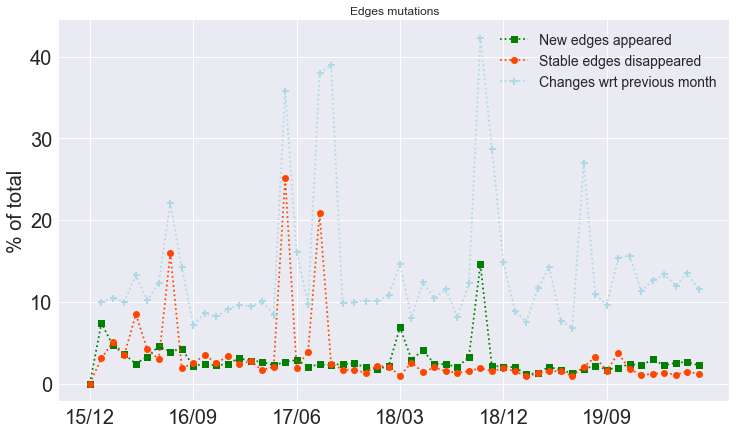

In [121]:
plt.figure(figsize=(12, 7))
plt.plot(as_graph_cumul_x_label, list(map(lambda x: 100* x, edge_novelty_fraction)), 's:', label="New edges appeared", color="green")
plt.plot(as_graph_cumul_x_label, list(map(lambda x: 100* x, edge_disappearence_fraction)), 'o:', label="Stable edges disappeared", color="orangered")
plt.plot(as_graph_cumul_x_label[1:], list(map(lambda x: 100* x, edges_num_change)), 'P:', label="Changes wrt previous month", color="lightblue")
plt.xticks(as_graph_cumul_x_ticks)
plt.title("Edges mutations")
plt.ylabel("% of total")
plt.legend()

`edge_novelty_fraction` (green in the graph) represents the fraction of edges at time $k$ that had never appeared previously
`edge_disappearence_fraction` (orange in the graph) represents the fraction of edges that were always present up to time $k-1$ but disappeared at time $k$. In symbols:

$$ \text{edge_novelty_fraction}[k] = \frac{\big \lvert E_S^k \setminus \bigcup_{j=0}^{k-1} E_S^j \big \rvert}{\lvert E_S^k \rvert} $$
and
$$ \text{edge_disappearence_fraction}[k] = \frac{\big \lvert \bigcap_{j=0}^{k-1} E_S^j \setminus E_S^k \big \rvert}{\big \lvert \bigcap_{j=0}^{k-1} E_S^j \big \rvert} $$

**DISCLAIMER**: *It must be noted that the previous metrics are highly unstable at the beginning (first months) and then gradually converge to truthful values*

#### Edge type change
How often edges change their type?

`fast_edges_type` is a dictionary containing, for each time $k$, a numpy array of the encoded edges of the *entire* graph $\Gamma^k$, along with their type

In [98]:
fast_edges_type = dict()
for i in x_vals:
    fast_edges_type[i] = np.concatenate([
        np.expand_dims((as_data[i]['edges'][:,0].astype('int64') * 1000000) + as_data[i]['edges'][:,1].astype('int64'), axis=1), 
        np.expand_dims(as_data[i]['edges'][:,2], axis=1)], axis=1)

`stable_edges_type` is a dictionary containing, for each time $k$, a numpy array of the **sorted** encoded edges of the **stable** subgraph $\Gamma_S^k$ along with their type

In [99]:
stable_edges_type = dict()
for i in x_vals:
    stable_idxs = np.in1d(fast_edges_type[i][:,0], edge_intersection)
    stable_edges_type[i] = fast_edges_type[i][stable_idxs,:][np.argsort(fast_edges_type[i][stable_idxs,0]),:]

In [100]:
# Just a sanity check
assert sum([np.sum(stable_edges_type[a][:,0] != stable_edges_type[b][:,0]) for (a, b) in zip(x_vals[:-1], x_vals[1:])]) == 0, "Didn't successfully compute the sorted stable edges"

In [101]:
edge_type_change_fraction = []
stable_edges_count = float(edge_intersection.shape[0])
for curr, nxt in zip(x_vals[:-1], x_vals[1:]):
    edge_type_change_fraction.append(np.sum(stable_edges_type[curr][:,1] != stable_edges_type[nxt][:,1]) / stable_edges_count)

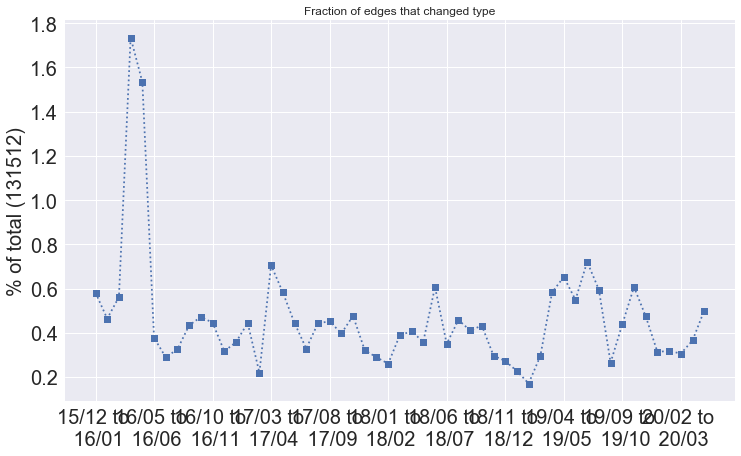

In [102]:
plt.figure(figsize=(12, 7))
plt.plot(as_graph_x_label, list(map(lambda x: 100*x, edge_type_change_fraction)), 's:')
plt.title("Fraction of edges that changed type")
plt.xticks(as_graph_x_ticks)
plt.ylabel("%% of total (%d)" % int(stable_edges_count));

Only a small amount of stable edges change of type (~0.4%)

In [103]:
edge_type_detail = []
for curr, nxt in zip(x_vals[:-1], x_vals[1:]):
    edge_type_detail.append([
        np.sum((stable_edges_type[curr][:,1] * 10 + stable_edges_type[nxt][:,1]) == 10) / stable_edges_count,
        np.sum((stable_edges_type[curr][:,1] * 10 + stable_edges_type[nxt][:,1]) == 1) / stable_edges_count,
        np.sum((stable_edges_type[curr][:,1] * 10 + stable_edges_type[nxt][:,1]) == 9) / stable_edges_count])
edge_type_detail = np.asarray(edge_type_detail)

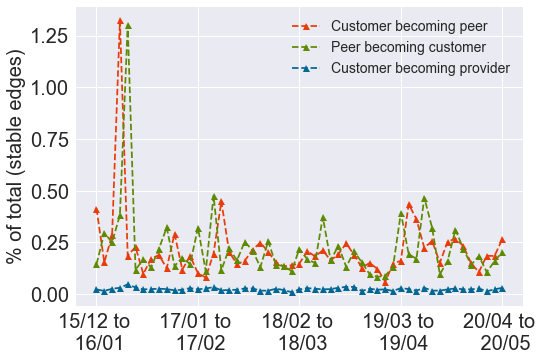

In [134]:
#plt.figure(figsize=(12, 7))
plt.plot(as_graph_x_label, 2 * edge_type_detail[:,0] * 100, '^--', color="#E73D0A", label="Customer becoming peer")
plt.plot(as_graph_x_label, 2 * edge_type_detail[:,1] * 100, '^--', color="#5E8A00", label="Peer becoming customer")
plt.plot(as_graph_x_label, 2 * edge_type_detail[:,2] * 100, '^--', color="#006793", label="Customer becoming provider")
plt.xticks(as_graph_x_ticks)
plt.ylabel("% of total (stable edges)")
#plt.title("Fraction of edges with different type")
plt.legend()
save_svg("edges_types_mut")

The previous graph details the nature of type change among edges of the stable subgraph.
It can be seen that:
 1. The number of inversions, i.e. *provider-to-customer* links becoming *customer-to-provider* ($\tau_k(\varepsilon) = 1$ and $\tau_{k+1}(\varepsilon) = -1$), is **very low** as expected
 2. The shape of the other two lines (depicting *customer-to-provider* links becoming *peer-to-peer* and vice versa) are almost **shifted versions** of each other: this suggest that many of those changes are just **noise**

### Save edges evolution between two consecutive months
I do between March and April 2020

In [70]:
first_month = '202003'
second_month = '202004'

A few useful functions

In [68]:
def convert_to_fast_edges(edges_param):
    return edges_param[:,0].astype('int64') * 1000000 + edges_param[:,1].astype('int64')

In [69]:
def revert_from_fast_edges(fast_edges_param):
    return np.concatenate(
        [(fast_edges_param / 1000000)[...,np.newaxis], (fast_edges_param % 1000000)[...,np.newaxis]], axis=1).astype(int)

In [102]:
# Remove double entries (leave only 1 entry for each edge)
def convert_to_asymmetric_edge_notation(symm_edges):
    double_disappearing_sorted = np.sort(symm_edges)
    double_reversed_disappearing_sorted = convert_to_fast_edges(revert_from_fast_edges(double_disappearing_sorted)[:,[1,0]])

    reversed_disappearing_idxs = np.argsort(double_reversed_disappearing_sorted)

    single_disappearing_to_keep = np.arange(0, double_disappearing_sorted.shape[0], 1) <= reversed_disappearing_idxs

    single_disappearing_without_duplicates = np.unique(double_disappearing_sorted[single_disappearing_to_keep])
    
    # Sanity check
    assert single_disappearing_without_duplicates.shape[0] == double_disappearing_sorted.shape[0] / 2
    
    edges_disappearing = revert_from_fast_edges(single_disappearing_without_duplicates)
    
    return edges_disappearing

Denoting with $a$ and $b$ the two consecutive months, the nodes I consider are $ V = A_a $ and the edges $ \tilde{E_a} = E^a $ and $ \tilde{E_b} = E^b|_V $.
I denote with $D_1 = \tilde{E_a} \setminus \tilde{E_b}$ the set of edges that disappeared

In [109]:
considered_nodes = as_data[first_month]['nodes']

In [110]:
edges_first = filter_by_nodes(as_data[first_month]['edges'], considered_nodes)
# Just sanity check
assert (edges_first == as_data[first_month]['edges']).all()
fast_first = convert_to_fast_edges(edges_first)

In [111]:
edges_second = filter_by_nodes(as_data[second_month]['edges'], considered_nodes)
fast_second = convert_to_fast_edges(edges_second)

In [112]:
print("Fration of edges of the second month contained in subgraph generated by V: %.2f%%" % (100 * float(fast_second.shape[0]) / as_data[second_month]['edges'].shape[0]))

Fration of edges of the second month contained in subgraph generated by V: 99.64%


In [113]:
fast_disappearing = np.setdiff1d(fast_first, fast_second)

In [114]:
print("Fraction of edges disappearing: %.2f%%" % (100 * float(fast_disappearing.shape[0]) / fast_first.shape[0]))

Fraction of edges disappearing: 9.18%


In [115]:
asymm_disappearing = convert_to_asymmetric_edge_notation(fast_disappearing)

I now also add (most of) the edges disappeared during the second month, in this case between April and May 2020
$\tilde{E_c} = E^c|_V$ and the disappearing edges I consider are $D_2 = (\tilde{E_a} \setminus \tilde{E_c}) \setminus D_1 = \tilde{E_a} \setminus (\tilde{E_c} \cup D_1)$

In [116]:
third_month = '202005'

In [117]:
edges_third = filter_by_nodes(as_data[third_month]['edges'], considered_nodes)
fast_third = convert_to_fast_edges(edges_third)

In [118]:
print("Fration of edges of the third month contained in subgraph generated by V: %.2f%%" % (100 * float(fast_third.shape[0]) / as_data[third_month]['edges'].shape[0]))

Fration of edges of the third month contained in subgraph generated by V: 99.17%


In [119]:
fast_disappearing_2 = np.setdiff1d(np.setdiff1d(fast_first, fast_third), fast_disappearing)

In [120]:
print("Fraction of edges disappearing: %.2f%%" % (100 * float(fast_disappearing_2.shape[0]) / fast_first.shape[0]))

Fraction of edges disappearing: 6.38%


In [121]:
asymm_disappearing_2 = convert_to_asymmetric_edge_notation(fast_disappearing_2)

#### Save disappearing edges for simulation

In [122]:
# Randomly shuffle the array: Should shuffle while maintaing month boundaries
np.random.shuffle(asymm_disappearing)
np.random.shuffle(asymm_disappearing_2)

In [125]:
# Choose the disappearing edges to save
to_save_disappearing = np.concatenate([asymm_disappearing, asymm_disappearing_2])
to_save_disappearing

array([[ 39120, 265172],
       [ 60501, 262545],
       [ 28890,  47321],
       ...,
       [ 18616,  56665],
       [198984, 267613],
       [  5495,  42678]])

In [129]:
# Sanity check:
# Edges do not appear more than once
assert np.unique(convert_to_fast_edges(to_save_disappearing)).shape[0] == to_save_disappearing.shape[0]

In [131]:
# Save to .csv file
# ------ CHANGE start and end months accordingly -------
start_month = first_month
end_month = third_month

#np.savetxt("./simulation/data/" + start_month + "-to-" + end_month + "-disappearing.csv", to_save_disappearing, fmt="%d", delimiter=",")

## Lab

In [138]:
a = np.array([11, 11, 12, 13, 21, 31, 44, 44])
b = np.array([11, 11, 21, 31, 12, 13, 44, 44])

In [139]:
a_pos = np.arange(0, a.shape[0], 1)
b_pos = np.argsort(b)
to_keep = a_pos <= b_pos

In [140]:
a_pos, b_pos, to_keep

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([0, 1, 4, 5, 2, 3, 6, 7], dtype=int64),
 array([ True,  True,  True,  True, False, False,  True,  True]))

In [141]:
np.unique(a[to_keep])

array([11, 12, 13, 44])